<a href="https://colab.research.google.com/github/punam-gwachha/Bone-Segmentation/blob/main/1Bone_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1.Bone Segmentation**

installation

In [99]:
!pip install  simpleitk pandas scikit-image

In [100]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.morphology import binary_dilation, ball
from skimage import measure
import pandas as pd #  pandas for saving landmarks

Image load and visualize the original image

Text(0.5, 1.0, 'Original Mask')

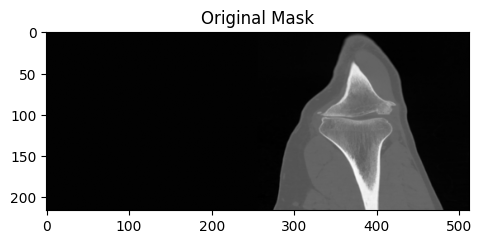

In [101]:
# Load the image
image = sitk.ReadImage("//content/3702_left_knee.nii")
data = sitk.GetArrayFromImage(image)

### --- Display Slice --- ###
slice_idx = data.shape[1] // 2
plt.figure(figsize=(12, 12))
plt.subplot(1,2,1);
plt.imshow(data[:, slice_idx,: ], cmap="gray");
plt.title("Original Mask")

image preprocessing:thresholding

In [102]:
# thresholding to isolate bone regions (bones have high Hounsfield Units, typically > 700 & <3000).
# creates a binary mask that isolates bone tissue in a CT scan.
bone_mask = (data > 500) & (data < 3000)

In [103]:
# Connected Component Analysis – Identify femur and tibia based on size, shape, and position.
# Label connected components
labeled_mask = label(bone_mask)
regions = regionprops(labeled_mask)

# Sort regions by size (femur and tibia are usually the two largest)
regions_sorted = sorted(regions, key=lambda x: x.area, reverse=True)

# Assume femur is the first largest, tibia the second largest
femur_mask = (labeled_mask == regions_sorted[0].label)
tibia_mask = (labeled_mask == regions_sorted[1].label)


In [104]:
# Create RGB volume for segmentation (red=femur, green=tibia)
rgb_volume = np.zeros((*data.shape, 3), dtype=np.uint8)
rgb_volume[femur_mask] = [255, 0, 0]  # Red for femur
rgb_volume[tibia_mask] = [0, 255, 0]  # Green for tibia

# Convert RGB volume to SimpleITK image
rgb_image = sitk.GetImageFromArray(rgb_volume)
rgb_image.CopyInformation(image)  # Preserve metadata


In [105]:
# Save the segmented image
sitk.WriteImage(rgb_image, "segmented_femur_tibia.nii.gz")

Display original and semgmented

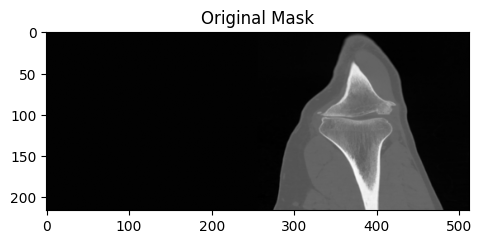

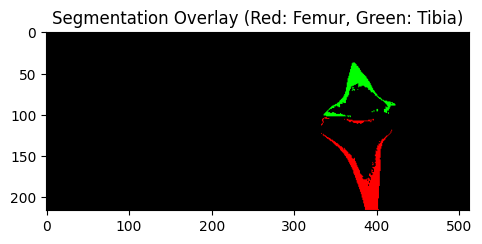

In [106]:
slice_idx = data.shape[1] // 2
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1);
plt.imshow(data[:, slice_idx,: ], cmap="gray");
plt.title("Original Mask")
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1,2,2);
plt.imshow(rgb_volume[:, slice_idx,: ], cmap="gray");
plt.title("Segmentation Overlay (Red: Femur, Green: Tibia)")
plt.show()


Task 1.2 contour Expanision

In [107]:
# Load the segmented mask from Task 1.1
mask_img = sitk.ReadImage("/content/segmented_femur_tibia.nii.gz")
mask_data_rgb = sitk.GetArrayFromImage(mask_img).astype(np.uint8)

# Create a binary mask from the RGB data
# A pixel is considered part of the mask if any of its RGB channels are non-zero
mask_data_binary = np.any(mask_data_rgb > 0, axis=-1)

# Get pixel spacing (assumes isotropic spacing)
pixel_spacing = mask_img.GetSpacing()[0]  # in mm (e.g., 0.5 mm/pixel)
expansion_mm = 2.0  # Parameter: expand by 2 mm

# Convert mm to pixels
# The radius should be an integer for the ball kernel
radius_pixels = int(np.round(expansion_mm / pixel_spacing))

# Create a spherical kernel for 3D dilation
# The kernel should match the dimensions of the binary mask (3D)
kernel = ball(radius_pixels)

# Dilate the binary mask
expanded_mask = binary_dilation(mask_data_binary, kernel)

# Save the expanded mask
expanded_img = sitk.GetImageFromArray(expanded_mask.astype(np.uint8))
expanded_img.CopyInformation(mask_img) # Copy metadata from the original image
sitk.WriteImage(expanded_img, "expanded_mask_2mm.nii.gz")

display the original and sgmented mask

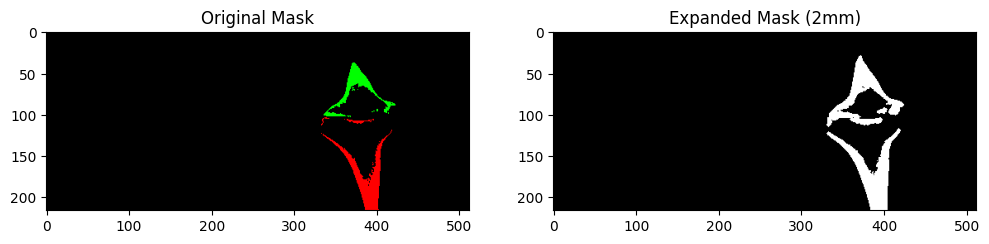

In [108]:
slice_idx = mask_data_rgb.shape[1] // 2
plt.figure(figsize=(12, 6))
plt.subplot(121); plt.imshow(mask_data_rgb[:, slice_idx,: ], cmap="gray"); plt.title("Original Mask")

plt.subplot(122); plt.imshow(expanded_mask[:, slice_idx,:], cmap="gray"); plt.title("Expanded Mask (2mm)")
plt.show()

Task 3 randomized mask

In [109]:
# Load the original segmented mask (from Task 1.1)
mask_img = sitk.ReadImage("/content/segmented_femur_tibia.nii.gz")

# Use SimpleITK.GetArrayFromImage to get the numpy array
mask_data = sitk.GetArrayFromImage(mask_img).astype(np.uint8)

# Create a binary mask from the RGB data
# A pixel is considered part of the mask if any of its RGB channels are non-zero
mask_data_binary = np.any(mask_data > 0, axis=-1)

# Parameters
expansion_mm = 2.0  # Max expansion (mm)
random_factor = 0.5  # Randomness control (0=original, 1=fully expanded)

# Get pixel spacing (assume isotropic(same value in all direction) for simplicity)
# Use mask_img.GetSpacing() for SimpleITK image
pixel_spacing = mask_img.GetSpacing()[0]
radius_pixels = int(np.round(expansion_mm / pixel_spacing))

# Generate expanded mask (Task 1.2)
kernel = ball(radius_pixels)
# Use the binary mask for dilation
expanded_mask = binary_dilation(mask_data_binary, kernel)

# Compute the difference region (area between original and expanded)
difference_region = expanded_mask & (~mask_data_binary) # Use the binary mask here too

# Randomly select a subset of the difference region
# Initialize randomized_mask with the original binary mask
randomized_mask = mask_data_binary.copy()
if random_factor > 0:
    # Get coordinates of difference region
    coords = np.argwhere(difference_region)
    # Randomly select a fraction of these coords
    num_random = int(len(coords) * random_factor)
    selected_coords = coords[np.random.choice(len(coords), num_random, replace=False)]
    # Add them to the original mask
    randomized_mask[tuple(selected_coords.T)] = 1

# Ensure no shrinkage below original mask
randomized_mask = randomized_mask | mask_data_binary

# Save the randomized mask
# Since the randomized mask is a numpy array, convert it back to SimpleITK Image
randomized_img = sitk.GetImageFromArray(randomized_mask.astype(np.uint8))
randomized_img.CopyInformation(mask_img) # Copy metadata from the original image
sitk.WriteImage(randomized_img, "randomized_mask.nii.gz")

display original,2mm expanded and randomized mask

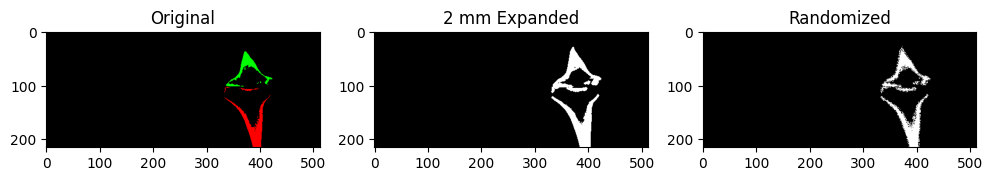

In [110]:
slice_idx = mask_data.shape[2] // 2
plt.figure(figsize=(12, 12))
plt.subplot(131); plt.imshow(mask_data[:,slice_idx, :], cmap="gray"); plt.title("Original")
plt.subplot(132); plt.imshow(expanded_mask[:, slice_idx,:], cmap="gray"); plt.title("2 mm Expanded")
plt.subplot(133); plt.imshow(randomized_mask[:, slice_idx,:], cmap="gray"); plt.title("Randomized")
plt.show()

Task 4 Landmark detection

save tibia_original mask

In [115]:
tibia_mask = (labeled_mask == regions_sorted[1].label)

tibia_mask_array = (labeled_mask == regions_sorted[1].label)

# Convert the NumPy array mask to a SimpleITK Image
# Cast to uint8 as binary masks are typically stored this way (0 or 1)
tibia_mask_img = sitk.GetImageFromArray(tibia_mask_array.astype(np.uint8))

# Copy metadata from the original CT image
# The 'image' variable should hold the SimpleITK image object loaded earlier
tibia_mask_img.CopyInformation(image)

# Save original tibia mask
sitk.WriteImage(tibia_mask_img, "tibia_original.nii.gz")

Generate expanded masks (2mm and 4mm) and save tibia_2mm amd 4mm.ni.gz

In [112]:

# Get pixel spacing using SimpleITK's GetSpacing()
pixel_spacing = image.GetSpacing()[0]  # Assumes isotropic spacing

def expand_mask(mask_img, mm):
    # Get array from SimpleITK image
    mask_array = sitk.GetArrayFromImage(mask_img)
    # Convert mm to pixels using the image's spacing
    radius_pixels = int(np.round(mm / mask_img.GetSpacing()[0]))
    # Create a spherical kernel for 3D dilation
    kernel = ball(radius_pixels)
    # Perform dilation
    expanded_array = binary_dilation(mask_array, kernel)
    # Convert the resulting numpy array back to a SimpleITK image
    expanded_img = sitk.GetImageFromArray(expanded_array.astype(np.uint8))
    # Copy original image information
    expanded_img.CopyInformation(mask_img)
    return expanded_img

# Expand the tibia mask using the SimpleITK image object `tibia_mask_img`
tibia_2mm_img = expand_mask(tibia_mask_img, 2)
tibia_4mm_img = expand_mask(tibia_mask_img, 4)

# Save the expanded SimpleITK images
sitk.WriteImage(tibia_2mm_img, "tibia_2mm.nii.gz")
sitk.WriteImage(tibia_4mm_img, "tibia_4mm.nii.gz")

Generate randomized masks (Task 1.3) and save tibia_random1 and random2

In [113]:

def randomize_mask(mask_img, expanded_mask_img, random_factor):
    # Get numpy arrays from SimpleITK images
    mask_array = sitk.GetArrayFromImage(mask_img)
    expanded_mask_array = sitk.GetArrayFromImage(expanded_mask_img)

    # Compute the difference region (expanded but not original) using numpy boolean operations
    diff_region = expanded_mask_array & (~mask_array)

    coords = np.argwhere(diff_region)

    # Initialize randomized_mask with the original mask array
    randomized_array = mask_array.copy()

    # Handle case where diff_region is empty
    if len(coords) > 0 and random_factor > 0:
        # Randomly select a fraction of these coords
        num_random = int(len(coords) * random_factor)
        selected_coords = coords[np.random.choice(len(coords), num_random, replace=False)]
        # Add them to the original mask
        # Note: np.argwhere returns coords in (z, y, x) order for SimpleITK/NumPy arrays
        randomized_array[selected_coords[:, 0], selected_coords[:, 1], selected_coords[:, 2]] = 1

    # Ensure no shrinkage below original mask (this line might not be strictly necessary
    # if you start with the original mask and only add to it, but it's good practice)
    randomized_array = randomized_array | mask_array

    # Convert the resulting numpy array back to a SimpleITK image
    randomized_img = sitk.GetImageFromArray(randomized_array.astype(np.uint8))
    # Copy original image information
    randomized_img.CopyInformation(mask_img) # Copy metadata from the original image

    return randomized_img

# Call the function with SimpleITK image objects
tibia_rand1 = randomize_mask(tibia_mask_img, tibia_2mm_img, random_factor=0.5)
tibia_rand2 = randomize_mask(tibia_mask_img, tibia_2mm_img, random_factor=0.8)

sitk.WriteImage(tibia_rand1, "tibia_random1.nii.gz")
sitk.WriteImage(tibia_rand2, "tibia_random2.nii.gz")

Detect Medial & Lateral Lowest Points

In [114]:
def find_lowest_points(mask_img, original_ct_img):
    # Get numpy array from the mask SimpleITK Image
    mask_array = sitk.GetArrayFromImage(mask_img)

    # Get lowest slice with tibia in the mask array
    # Check if the mask is empty
    if not np.any(mask_array):
        print(f"Warning: Mask is empty (from mask_img)")
        return None, None # Or handle empty mask appropriately

    # In SimpleITK/NumPy, z is the first dimension
    z_coords = np.argwhere(mask_array)[:, 0]
    # Handle case where mask_array is not empty but z_coords is (shouldn't happen with np.any check, but defensive)
    if len(z_coords) == 0:
         print("Warning: np.any(mask_array) was true but np.argwhere returned empty.")
         return None, None
    lowest_slice = np.min(z_coords)  # Inferior-most slice index

    # Extract 2D contour in the lowest slice
    contour_slice = mask_array[lowest_slice, :, :] # Slice in (y, x) order
    contours = measure.find_contours(contour_slice, 0.5)

# Handle case where no contours are found (e.g., very small mask)
    if not contours:
         print(f"Warning: No contours found in lowest slice {lowest_slice}")
         return None, None

    # Assuming largest contour is the tibia contour in this slice
    # Handle case where contours is not empty but contains only tiny contours
    if not any(len(c) > 1 for c in contours): # Check if any contour has more than 1 point
        print(f"Warning: No substantial contours found in lowest slice {lowest_slice}")
        return None, None

    main_contour = max(contours, key=len)
    # find_contours returns (row, col) which correspond to (y, x)
    y_contour, x_contour = main_contour[:, 0], main_contour[:, 1]

    # Find medial (min x index) and lateral (max x index) points on the contour
    # Note: These are pixel indices within the 2D slice
    medial_idx = np.argmin(x_contour)
    lateral_idx = np.argmax(x_contour)

    # Get the (x, y) pixel coordinates from the contour arrays
    medial_pixel_xy = (x_contour[medial_idx], y_contour[medial_idx])
    lateral_pixel_xy = (x_contour[lateral_idx], y_contour[lateral_idx])

    # Construct the voxel coordinates (x, y, z) for the original 3D volume
    # SimpleITK/NumPy uses (z, y, x) order for arrays
    # SimpleITK TransformContinuousIndexToPhysicalPoint expects (x, y, z) as input
    # So we need to reorder the (y, x) pixel coordinates and use the z slice index.
    # The voxel index tuple for SimpleITK (x, y, z) should be (medial_pixel_xy[0], medial_pixel_xy[1], lowest_slice)
    # This matches what was already there, which is correct for SimpleITK input order.
    medial_voxel_sitk_order = (medial_pixel_xy[0], medial_pixel_xy[1], lowest_slice)
    lateral_voxel_sitk_order = (lateral_pixel_xy[0], lateral_pixel_xy[1], lowest_slice)

    # Convert voxel coordinates to physical coordinates using SimpleITK's method
    # Ensure the input is a sequence of doubles as required by the error message
    medial_physical = original_ct_img.TransformContinuousIndexToPhysicalPoint([float(medial_voxel_sitk_order[0]), float(medial_voxel_sitk_order[1]), float(medial_voxel_sitk_order[2])])
    lateral_physical = original_ct_img.TransformContinuousIndexToPhysicalPoint([float(lateral_voxel_sitk_order[0]), float(lateral_voxel_sitk_order[1]), float(lateral_voxel_sitk_order[2])])

    # These are already in physical (world) coordinates (x, y, z)
    return medial_physical, lateral_physical


# Detect landmarks for all masks
masks = {
    "Original": tibia_mask_img, # Use the SimpleITK image objects
    "2mm": tibia_2mm_img,
    "4mm": tibia_4mm_img,
    "Random1": tibia_rand1,
    "Random2": tibia_rand2
}

landmarks = {}
# Use the original ct_image (SimpleITK object) to get the transformation info
original_ct_simpleitk = sitk.ReadImage("/content/3702_left_knee.nii")

for name, mask_img_sitk in masks.items():
    print(f"Processing mask: {name}") # Added print for tracking progress
    # Pass the SimpleITK mask image and the original CT SimpleITK image
    medial, lateral = find_lowest_points(mask_img_sitk, original_ct_simpleitk)

    # Only store landmarks if they were successfully found
    if medial is not None and lateral is not None:
        # Convert SimpleITK Points (tuple) to NumPy arrays or lists for consistency
        landmarks[name] = {"Medial": list(medial), "Lateral": list(lateral)}
    else:
        # Store None if landmarks were not found for this mask
        landmarks[name] = {"Medial": None, "Lateral": None}


# Save landmarks to CSV
import pandas as pd
# Create DataFrame from the dictionary
df = pd.DataFrame.from_dict(landmarks, orient="index")
df.to_csv("tibia_landmarks.csv")

# Optional: Display the DataFrame
print("\nLandmark Detection Results:") # Added heading
print(df)

Processing mask: Original
Processing mask: 2mm
Processing mask: 4mm
Processing mask: Random1
Processing mask: Random2

Landmark Detection Results:
                                                   Medial  \
Original  [75.18078655004501, 32.158307909965515, -900.5]   
2mm       [73.44250458478928, 32.158307909965515, -900.5]   
4mm       [70.83508163690567, 32.158307909965515, -900.5]   
Random1   [73.44250458478928, 31.289166927337646, -900.5]   
Random2   [73.44250458478928, 32.158307909965515, -900.5]   

                                                   Lateral  
Original   [102.12415701150894, 15.64462924003601, -900.5]  
2mm        [103.86243897676468, 15.64462924003601, -900.5]  
4mm        [106.46986192464828, 15.64462924003601, -900.5]  
Random1   [103.86243897676468, 17.382911205291748, -900.5]  
Random2    [103.86243897676468, 16.51377022266388, -900.5]  
